# Outline 

## PCA Analysis

0. Get historical daily par curve data from [here](https://github.com/epogrebnyak/data-ust).
1. Interpolate the daily YC data till 120 points at 3 month freq
2. Do PCA, compute covariance matrix, do eigendecomposition.
3. Replicate PCA against maturity plot and table.

## Signal Generation (Blocker)

1. Use third PCs to generate signals (weights of the butterfly). Rolling window, then 1Y wait period, then trade.
2. Code up same, via various parameter input, generate signals

## PnL Calculation (Blocker)

1. Calculate yield pickup per trade in bps


In [61]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn import linear_model
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

## Yield Curve Interpolation (Daily Par Rates)

In [2]:
def interpolate_row(row):
    cs = CubicSpline(tenor_months, row)
    return cs(new_tenors)


raw_yields = pd.read_csv('daily_par_curve.csv', index_col='date', parse_dates=True).iloc[:,:-1]
raw_yields = raw_yields[raw_yields.index >= '2012'] * 100

tenor_months = np.array([1, 3, 6, 12, 24, 36, 60, 72, 120, 240, 360])
new_tenors = np.arange(0,361,3)

yields = pd.DataFrame(raw_yields.apply(interpolate_row,axis=1).tolist(), columns = new_tenors, index=raw_yields.index)
yields.to_csv('daily_i_par_curve.csv')

In [3]:
yields = pd.read_csv("daily_i_par_curve.csv", index_col='date', parse_dates=True)

# PCA Analysis

In [4]:
pca = PCA(n_components=3)
pca.fit(yields)

PCA(n_components=3)

## Yield Curve Across Year Plot

## Components & Explained Variance

In [5]:
np.sqrt(pca.explained_variance_)

array([606.22862145, 316.93543624,  77.95088324])

In [6]:
pca.explained_variance_ratio_

array([0.77285606, 0.21123571, 0.01277815])

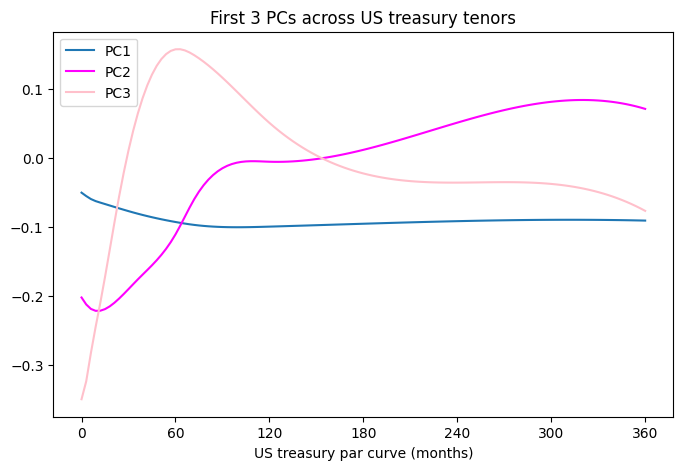

In [7]:

colors = {'PC1': 'tab:blue', 'PC2': 'fuchsia', 'PC3':'pink'}
pcs = pd.DataFrame(pca.components_).T
fig,ax =plt.subplots(1,1,figsize=(8,5))
pcs.index =yields.columns
pcs.columns = ['PC1', 'PC2', 'PC3']
pcs.plot(ax=ax, title='First 3 PCs across US treasury tenors', color=colors)
ax.set_xlabel("US treasury par curve (months)")
plt.show()

In [8]:
pcs

,PC1,PC2,PC3
0,-0.049938,-0.201896,-0.349392
3,-0.054880,-0.212020,-0.323378
6,-0.059195,-0.218484,-0.282188
9,-0.062180,-0.221253,-0.244626
12,-0.064363,-0.221065,-0.209565
...,...,...,...
348,-0.089894,0.078332,-0.063209
351,-0.090012,0.076889,-0.066189
354,-0.090140,0.075278,-0.069365
357,-0.090278,0.073496,-0.072743


In [9]:
pcs

,PC1,PC2,PC3
0,-0.049938,-0.201896,-0.349392
3,-0.054880,-0.212020,-0.323378
6,-0.059195,-0.218484,-0.282188
9,-0.062180,-0.221253,-0.244626
12,-0.064363,-0.221065,-0.209565
...,...,...,...
348,-0.089894,0.078332,-0.063209
351,-0.090012,0.076889,-0.066189
354,-0.090140,0.075278,-0.069365
357,-0.090278,0.073496,-0.072743


In [10]:
transformed = pca.transform(yields)
pca_across_time = pd.DataFrame(transformed, index=yields.index)
pca_across_time.columns=['PC1','PC2','PC3']


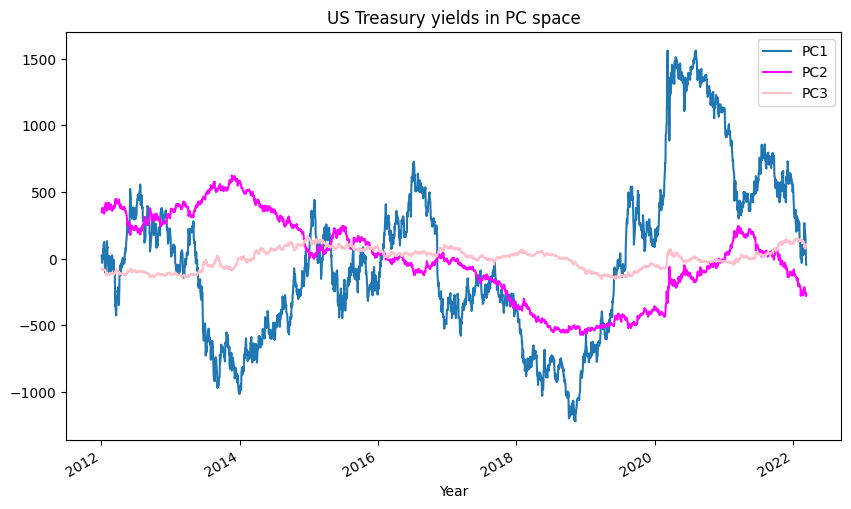

In [11]:
pca_across_time.rolling(1).mean().plot(figsize=(10,6), title='US Treasury yields in PC space', xlabel='Year',color=colors)
plt.show()

In [12]:
slope = yields['120'] - yields['24']
pc2 = pca_across_time.iloc[:,1]
slopes = pd.DataFrame({"slope":slope,"pc2":pc2})


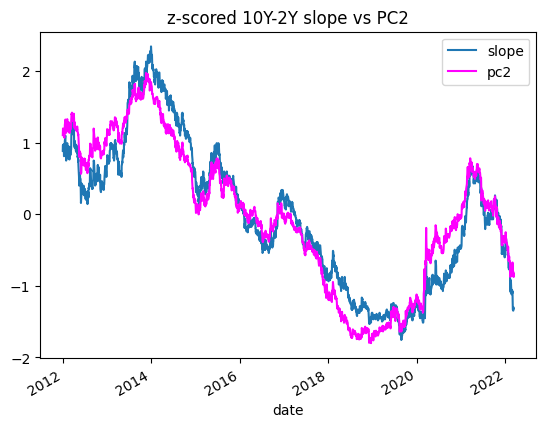

In [13]:
slopes.sub(slopes.mean()).div(slopes.std()).plot(title='z-scored 10Y-2Y slope vs PC2', color={"slope":"tab:blue","pc2":"fuchsia"})
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

In [14]:
slope

date
2012-01-03    170.0
2012-01-04    175.0
2012-01-05    175.0
2012-01-06    173.0
2012-01-09    172.0
              ...  
2022-03-07     23.0
2022-03-08     23.0
2022-03-09     26.0
2022-03-10     26.0
2022-03-11     25.0
Length: 2550, dtype: float64

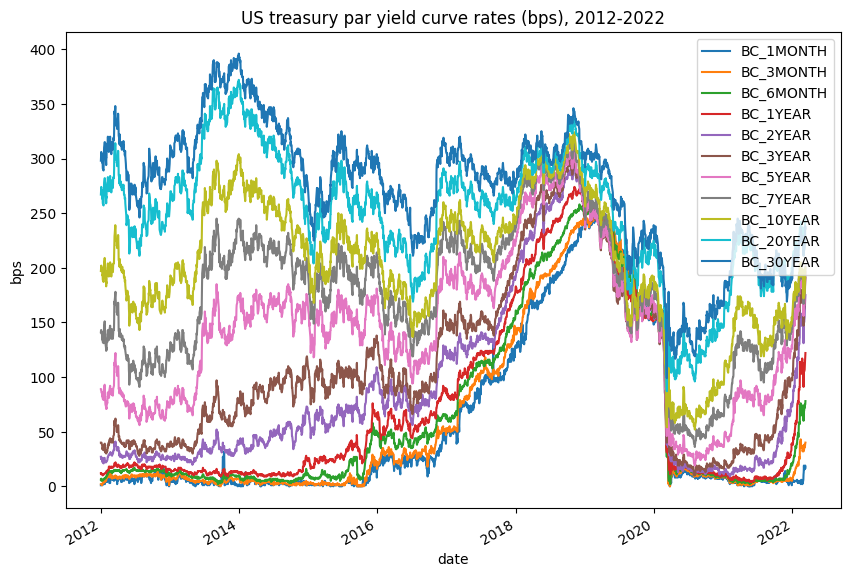

In [15]:
raw_yields.plot(figsize=(10,7), title='US treasury par yield curve rates (bps), 2012-2022', ylabel='bps')
plt.show()

# Butterfly Trades

In [16]:

def rolling_pca(yields, n):
    results = []
    for i in range(n, len(yields)):
        window = yields.iloc[i - n:i]
        pca = PCA(n_components=3)
        pca.fit(window)
        results.append(pca.components_[2])

    evolving_third_pc = pd.DataFrame(results, columns=yields.columns, index=yields.iloc[n:,:].index)

    return evolving_third_pc

def create_butterfly(yields, n, m1, m2, m3, z, ew=False):

    # extract the desired butterfly tenors from yield data
    m1, m2, m3 = str(m1*12), str(m2*12), str(m3*12)
    yields = yields.loc[:,[m1,m2,m3]]

    # compute rolling 3rd PC values
    raw = rolling_pca(yields, n)

    # normalize by belly. Try normal and z-scored weights
    weights = raw.div(raw[m2],axis=0)
    z_weights = weights.sub(weights.rolling(z).mean()).div(weights.rolling(z).std()).iloc[z:].fillna(1)

    # adjust for rolling window
    yields = yields.iloc[n:,:]
    z_yields = yields.iloc[z:,:]

    # compute butterfly spread
    fly = (yields * weights).sum(axis=1)
    z_fly = (z_yields * z_weights).sum(axis=1)

    if ew:
        fly = (yields * np.array([-0.5,1,-0.5])).sum(axis=1)

    return yields, weights, fly, z_yields, z_weights, z_fly

In [17]:

def butterfly_analytics(yields, fly):
    """ 
    Replicates some of the graphs in the SSB butterfly model
    
    * Butterfly spread over time
    * Butterfly vs center yield (exposure to PC1)
    * Butterfly vs curve slope (exposure to PC2)

    """

    y_vs_c = pd.DataFrame({"center":yields.iloc[:,1], "fly": fly})
    y_vs_s = pd.DataFrame({"slope":yields.iloc[:,2] - yields.iloc[:,0], "fly": fly})
    sns.reset_orig()
    fig,ax = plt.subplots(3,1, figsize=(10,11))

    ax[0].set_title("Butterfly spread (bps): 2s-5s-10s")
    ax[1].set_title("Butterfly vs center (bps)")
    ax[2].set_title("Butterfly vs slope: long wing - short wing (bps)")

    sns.lineplot(data=fly, color='fuchsia', ax=ax[0])
    # fly.plot(ax=ax[0], color='fuchsia')
    sns.regplot(data=y_vs_c, x="center", y="fly", scatter_kws={'s':10},ax=ax[1])
    sns.regplot(data=y_vs_s, x="slope", y="fly", scatter_kws={'s':10}, color='tab:red',ax=ax[2])

    c_text = regstats(y_vs_c['center'], y_vs_c['fly'])
    ax[1].annotate(c_text, xy=(0.01, 0.01), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="square,pad=0.3", facecolor="white"))

    s_text = regstats(y_vs_s['slope'], y_vs_s['fly'])
    ax[2].annotate(s_text, xy=(0.01, 0.01), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="square,pad=0.3", facecolor="white"))

    for x in ax:
        x.set_xlabel(None)
    
    plt.show()
    return 0 


 

def regstats(x,y):
    x,y =x.to_numpy().reshape(-1,1),y.to_numpy().reshape(-1,1)
    model = linear_model.LinearRegression()
    # Fit your regression model
    model.fit(x,y)

    # Get the regression coefficients
    beta = round(model.coef_[0][0],3)

    # Calculate R-squared (R2)
    y_pred = model.predict(x)
    r2 = round(r2_score(y, y_pred),3)

    # Calculate the Pearson correlation coefficient
    correlation = round(pearsonr(x.ravel(),y.ravel()).statistic,2)
    # correlation=0.58
    return f'Beta: {beta}\nR2: {r2}\nCorr: {correlation}'






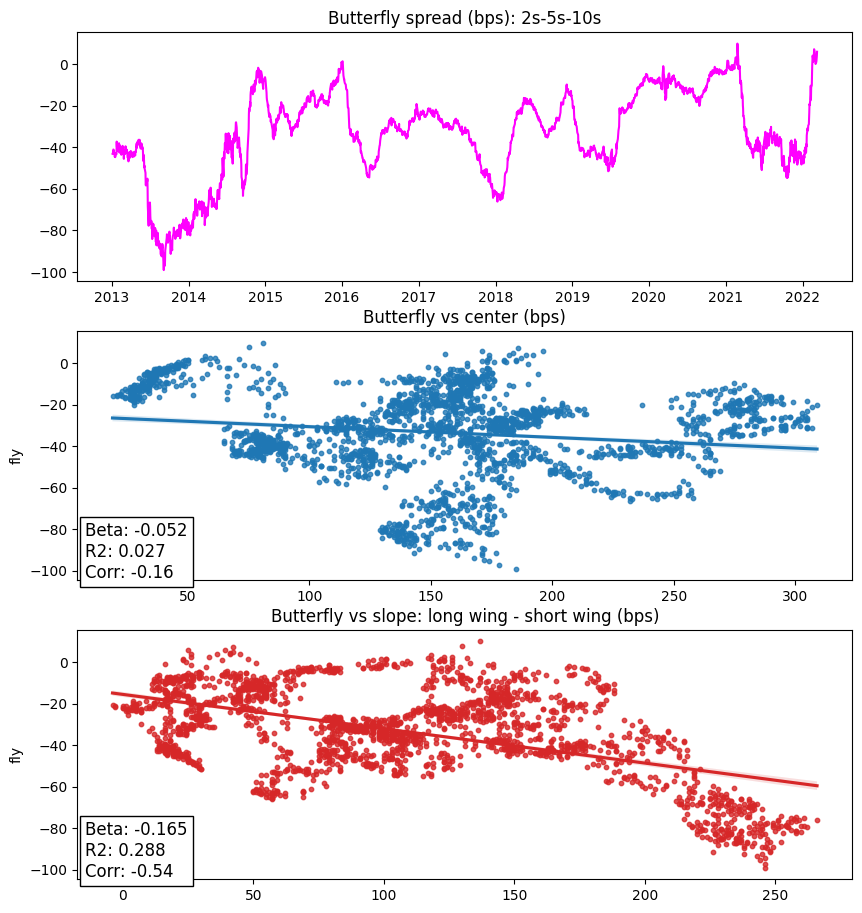

0

In [18]:
n = int (252 * 1)
y, w, fly, z_y, z_w, z_fly = create_butterfly(yields, n, 2, 5, 10, 30, ew=False)
butterfly_analytics(y, fly)

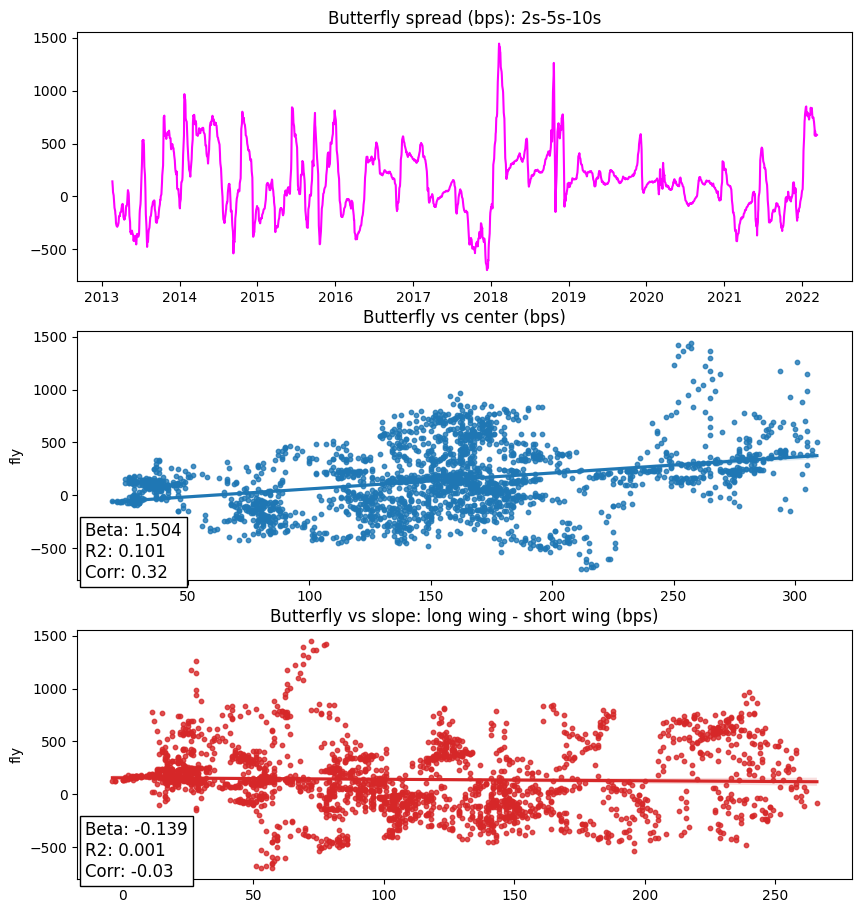

0

In [19]:
butterfly_analytics(z_y, z_fly)

In [20]:
n_yrs = [1,2,3,5]
df = pd.DataFrame(index=yields.iloc[5*252:,:].index)

for n in n_yrs:
    
    _, y, fly, _, _, _ = create_butterfly(yields, int(n*252), 2, 5, 10, 30, ew=False)

    df[f'{n}Y'] = fly[fly.index>='2017-01-17']    

n_yrs = [1,2,3,5]
ew_df = pd.DataFrame(index=yields.iloc[5*252:,:].index)

for n in n_yrs:
    
    _, _, fly, _, _, _ = create_butterfly(yields, int(n*252), 2, 5, 10, 30, ew=True)

    ew_df[f'{n}Y'] = fly[fly.index>='2017-01-17']   

In [21]:
level = yields['60'][5*252:]
slope = (yields['120']-yields['24'])[5*252:]


In [22]:
ew_df.columns = ['EW'] * 4

In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,7))


df.plot(ax=ax, ylabel='bps', fontsize=13)
ew_df.iloc[:,0].plot(ax=ax, color='grey', label='EW')
plt.title('2s-5s-10s butterfly spread (bps) for 1-5Y PCA rolling windows, 2017-2022', fontsize=14)
# plt.xlabel('date', fontsize=11)
# plt.subplots_adjust(left=0.05, right=0.95, top=0.05, bottom=0.95)
plt.savefig(r"C:\Users\Ryan\Desktop\website\analytic-musings.com\assets\images\SalomonBrothers\linkedin.png", dpi=100)
plt.show()

ValueError: bottom cannot be >= top

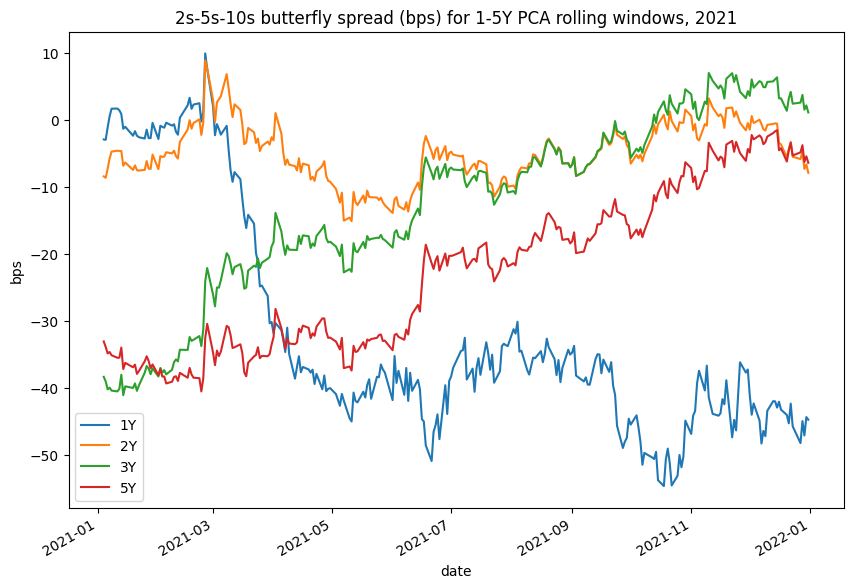

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
df[df.index.year==2021].plot(ax=ax, title='2s-5s-10s butterfly spread (bps) for 1-5Y PCA rolling windows, 2021', ylabel='bps')
plt.show()

# Weights & Rolling Correlations

In [25]:
w.plot(title='2s-5s-10s Butterfly PCA weights')

<AxesSubplot: title={'center': '2s-5s-10s Butterfly PCA weights'}, xlabel='date'>

In [26]:
z_w.plot(title='2s-5s-10s Butterfly z-scored PCA weights')

<AxesSubplot: title={'center': '2s-5s-10s Butterfly z-scored PCA weights'}, xlabel='date'>

In [27]:
def calculate_rolling_correlations(df, series, window_size):
    """
    Calculate rolling correlations between each column in a DataFrame and a Pandas Series.

    Parameters:
        df (pd.DataFrame): The DataFrame containing columns for which you want to calculate rolling correlations.
        series (pd.Series): The Pandas Series with which you want to calculate rolling correlations.
        window_size (int): The window size for rolling calculations.

    Returns:
        pd.DataFrame: A DataFrame containing rolling correlations for each column in the input DataFrame.
    """
    # Initialize an empty DataFrame to store the rolling correlations
    rolling_corr_df = pd.DataFrame()

    # Iterate through each column in the DataFrame
    for col_name, col_data in df.iteritems():
        # Calculate the rolling correlation with the Series
        rolling_corr = col_data.rolling(window=window_size).corr(series)
        
        # Append the result to the rolling_corr_df DataFrame with a meaningful column name
        rolling_corr_df[col_name + '_rolling_corr'] = rolling_corr

    return rolling_corr_df



calculate_rolling_correlations(df, level, 252).plot(title='Rolling 1Y correlation of PCA-weighted butterfly spread with 5s (center)')


C:\Users\Ryan\AppData\Local\Temp\ipykernel_37884\4237900566.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, col_data in df.iteritems():


<AxesSubplot: title={'center': 'Rolling 1Y correlation of PCA-weighted butterfly spread with 5s (center)'}, xlabel='date'>

In [28]:
calculate_rolling_correlations(df, slope, 252).plot(title='Rolling 1Y correlation of PCA-weighted butterfly spread with 10s-2s (slope)')


C:\Users\Ryan\AppData\Local\Temp\ipykernel_37884\4237900566.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, col_data in df.iteritems():


<AxesSubplot: title={'center': 'Rolling 1Y correlation of PCA-weighted butterfly spread with 10s-2s (slope)'}, xlabel='date'>